In [94]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')
from sklearn.decomposition import PCA
import torch
import torch.nn as nn
import torch.utils as utils
from torch.autograd import Variable
import torchvision.datasets as dset
import torchvision.transforms as transforms
from tqdm import tqdm_notebook

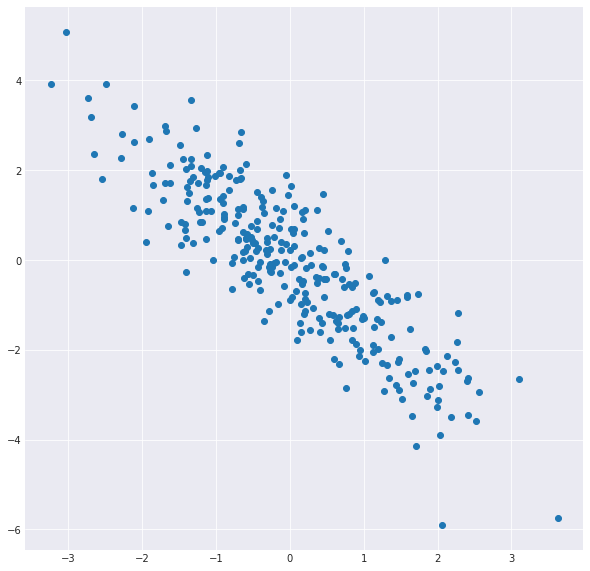

In [31]:
n_points = 100
mean = np.array([0.0, 0.0])
cov = np.array([[1.0, -1.0], 
                [-2.0, 3.0]])
X = np.random.multivariate_normal(mean, cov, 300)
plt.figure(figsize=(10, 10))
plt.scatter(X[:, 0], X[:, 1]);

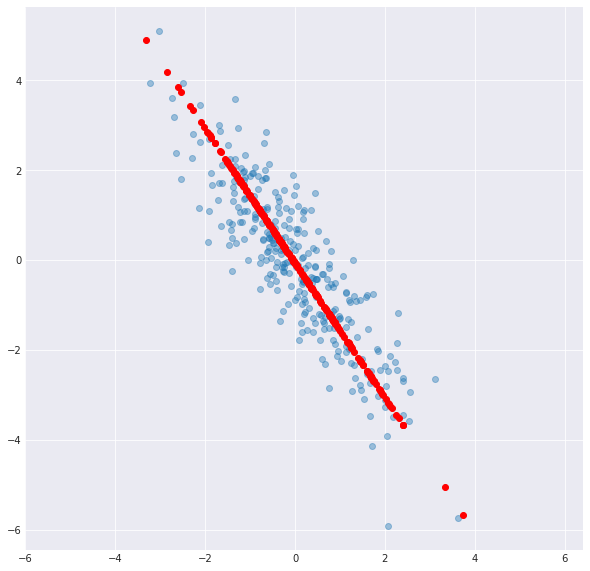

In [81]:
pca = PCA(n_components=1)
pca.fit(X)
X_transformed_pca = pca.inverse_transform(pca.transform(X))

plt.figure(figsize=(10, 10))
plt.axis('equal')
plt.scatter(X[:, 0], X[:, 1], alpha=0.4)
plt.scatter(X_transformed_pca[:, 0], X_transformed_pca[:, 1], color='r');

In [58]:
X_nn = Variable(torch.FloatTensor(X))
W_encoder = Variable(torch.FloatTensor(2, 1).normal_(mean=0., std=1.), requires_grad=True)
W_decoder = Variable(torch.FloatTensor(1, 2).normal_(mean=0., std=1.), requires_grad=True)
loss_func = nn.MSELoss()

parameters = [W_encoder, W_decoder]
optimizer = torch.optim.SGD(params=parameters, lr=0.01)

num_iters=100

for i in range(num_iters):
    optimizer.zero_grad()
    encoder_output = torch.mm(X_nn, W_encoder)
    decoder_output = torch.mm(encoder_output, W_decoder)
    loss = loss_func(decoder_output, X_nn)
    loss.backward()
    optimizer.step()

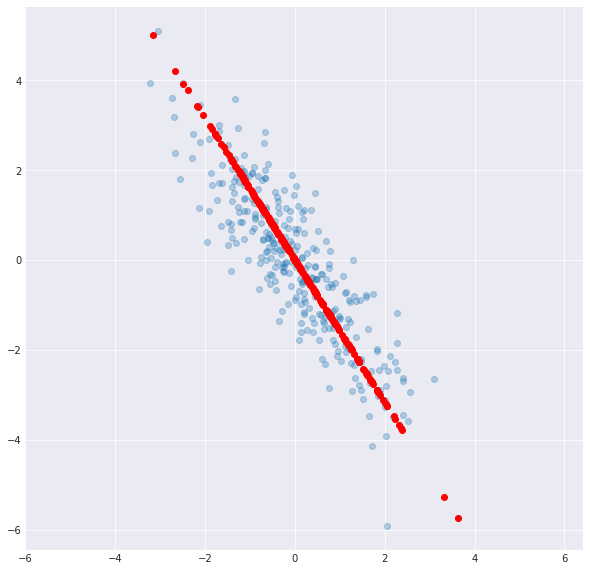

In [82]:
encoder_output = torch.mm(X_nn, W_encoder)
X_transformed_nn = torch.mm(encoder_output, W_decoder).data.numpy()

plt.figure(figsize=(10, 10))
plt.axis('equal')
plt.scatter(X[:, 0], X[:, 1], alpha=0.3);
plt.scatter(X_transformed_nn[:, 0], X_transformed_nn[:, 1], color='r');

In [85]:
batch_size = 32
mnist_train = dset.MNIST("./data", train=True, transform=transforms.ToTensor(), target_transform=None, download=True)
mnist_test  = dset.MNIST("./data", train=False, transform=transforms.ToTensor(), target_transform=None, download=True)
train_loader = torch.utils.data.DataLoader(dataset=mnist_train,batch_size=batch_size,shuffle=True)

In [86]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder,self).__init__()
        self.layer1 = nn.Sequential(
                        nn.Conv2d(1,32,3,padding=1),   # batch x 16 x 28 x 28
                        nn.ReLU(),
                        nn.BatchNorm2d(32),
                        nn.Conv2d(32,32,3,padding=1),   # batch x 16 x 28 x 28
                        nn.ReLU(),
                        nn.BatchNorm2d(32),
                        nn.Conv2d(32,64,3,padding=1),  # batch x 32 x 28 x 28
                        nn.ReLU(),
                        nn.BatchNorm2d(64),
                        nn.Conv2d(64,64,3,padding=1),  # batch x 32 x 28 x 28
                        nn.ReLU(),
                        nn.BatchNorm2d(64),
                        nn.MaxPool2d(2,2)   # batch x 64 x 14 x 14
        )
        self.layer2 = nn.Sequential(
                        nn.Conv2d(64,128,3,padding=1),  # batch x 64 x 14 x 14
                        nn.ReLU(),
                        nn.BatchNorm2d(128),
                        nn.Conv2d(128,128,3,padding=1),  # batch x 64 x 14 x 14
                        nn.ReLU(),
                        nn.BatchNorm2d(128),
                        nn.MaxPool2d(2,2),
                        nn.Conv2d(128,256,3,padding=1),  # batch x 64 x 7 x 7
                        nn.ReLU()
        )
        
                
    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(batch_size, -1)
        return out

In [87]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder,self).__init__()
        self.layer1 = nn.Sequential(
                        nn.ConvTranspose2d(256,128,3,2,1,1),
                        nn.ReLU(),
                        nn.BatchNorm2d(128),
                        nn.ConvTranspose2d(128,128,3,1,1),
                        nn.ReLU(),
                        nn.BatchNorm2d(128),
                        nn.ConvTranspose2d(128,64,3,1,1),
                        nn.ReLU(),
                        nn.BatchNorm2d(64),
                        nn.ConvTranspose2d(64,64,3,1,1),
                        nn.ReLU(),
                        nn.BatchNorm2d(64)
        )
        self.layer2 = nn.Sequential(
                        nn.ConvTranspose2d(64,32,3,1,1),
                        nn.ReLU(),
                        nn.BatchNorm2d(32),
                        nn.ConvTranspose2d(32,32,3,1,1),
                        nn.ReLU(),
                        nn.BatchNorm2d(32),
                        nn.ConvTranspose2d(32,1,3,2,1,1),
                        nn.ReLU()
        )
        
    def forward(self,x):
        out = x.view(batch_size,256,7,7)
        out = self.layer1(out)
        out = self.layer2(out)
        return out

In [90]:
encoder = Encoder()
decoder = Decoder()
learning_rate = 0.001

parameters = list(encoder.parameters())+ list(decoder.parameters())
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(parameters, lr=learning_rate)

In [98]:
epochs = 10
for epoch in range(epochs):
    for image, label in tqdm_notebook(train_loader):
        image_var = Variable(image)
        optimizer.zero_grad()
        encoder_output = encoder(image_var)
        decoder_output = decoder(encoder_output)
        loss = loss_func(decoder_output, image_var)
        loss.backward()
        optimizer.step()
    torch.save([encoder,decoder],'./model/mnist_autoencoder.pkl')
    print("Epoch: %d, Loss: %.5f" % (epoch, loss.data.numpy()[0]))

KeyboardInterrupt: 